Cross temporal decoding

HK 12.19.24

In [1]:
# imports
import numpy as np
import sys
import os
import time
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

In [2]:
def cross_temporal_decoding(fr, labels, n_folds = 10, random_state=42):
    """
    Implement cross-temporal decoding using LogisticRegression.
    
    Parameters:
    -----------
    fr : numpy.ndarray
        Firing rate data of shape (n_trials, n_times, n_units)
    labels : numpy.ndarray
        Trial labels of shape (n_trials,)
    n_folds : int
        Number of cross-validation folds (default: 10)
    random_state : int
        Random seed for reproducibility (default: 42)
        
    Returns:
    --------
    decoding_mean : numpy.ndarray
        Mean decoding accuracy matrix of shape (n_times, n_times)
    decoding_std : numpy.ndarray
        Standard deviation of decoding accuracy matrix of shape (n_times, n_times)

    """
    n_trials, n_times, n_units = fr.shape
    
    # Ensure labels is 1D
    labels = np.ravel(labels)  

    # Initialize cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)

    # Initialize decoder and results matrix
    decoder = GaussianNB()
    decoding_folds = np.zeros((n_folds, n_times, n_times))
    
    # Reshape firing rates for each timepoint
    fr_reshaped = fr.reshape(n_trials, -1, n_units)
    
    for fold_idx, (train_idx, test_idx) in enumerate(kf.split(fr_reshaped)):
        # Perform cross-temporal decoding for this fold
        for t1 in range(n_times):  # training time
            # Get data for training time point and scale
            X_train = fr_reshaped[train_idx, t1, :]
            y_train = labels[train_idx]
            
            # Train the model
            decoder.fit(X_train, y_train)
            
            for t2 in range(n_times):  # testing time
                # Get data for testing time point and scale
                X_test = fr_reshaped[test_idx, t2, :]
                y_test = labels[test_idx]
                
                # Test the model and store accuracy
                decoding_folds[fold_idx, t1, t2] = decoder.score(X_test, y_test)
    
    # Calculate mean and standard deviation across folds
    decoding_mean = np.mean(decoding_folds, axis=0)
    decoding_std = np.std(decoding_folds, axis=0)
    
    return decoding_mean, decoding_std


In [3]:
# which model and layer do we want to explore?
afc = 6
coh = 'lo'
mod = 0
layer = 3

# load RNN model and trials

if sys.platform.startswith('linux'):
        data_dir = f"/mnt/neurocube/local/serenceslab/holly/RNN_Geo/data/rdk_70_30_{afc}afc/feedforward_only/{coh}_coh"
else:
        data_dir = f"/Volumes/serenceslab/holly/RNN_Geo/data/rdk_70_30_{afc}afc/feedforward_only/{coh}_coh"
        
mat_files = [f for f in os.listdir(data_dir) if f.endswith('.mat') and not f.startswith('._')]# Get all the trained models (should be 40 .mat files)
model_path = os.path.join(data_dir, mat_files[mod]) 
model = loadmat(model_path)   
data_file = f"{data_dir}/Trials1000_model{model_path[-7:-4]}_neutral.npz"
data = np.load(data_file) #fr1 fr3 outs labs


# reshape firing rate data and get trial labels
fr = data[f'fr{layer}'] # shape (1000, 250, 200) trials x time x units
labels = data['labs']  # labels are 1D, shape (1000,)trials
#np.random.shuffle(labels) garbage in garbage out test

In [4]:
start_time = time.time() 
decoding_mean, decoding_std = cross_temporal_decoding(fr, labels)
end_time = time.time()
print(f"Execution time: {end_time - start_time} seconds")

Execution time: 427.56113862991333 seconds


In [5]:
save_figures = False

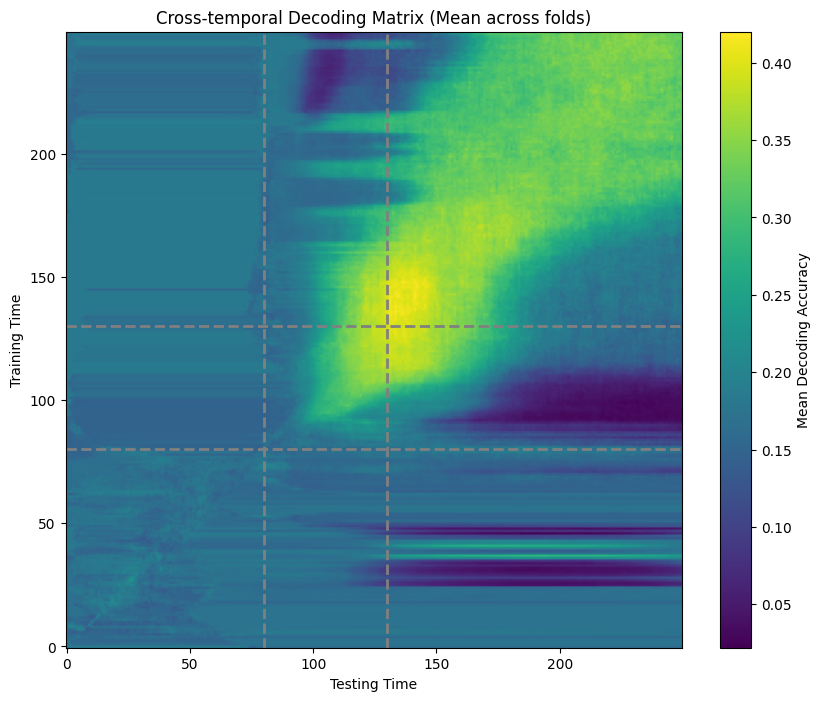

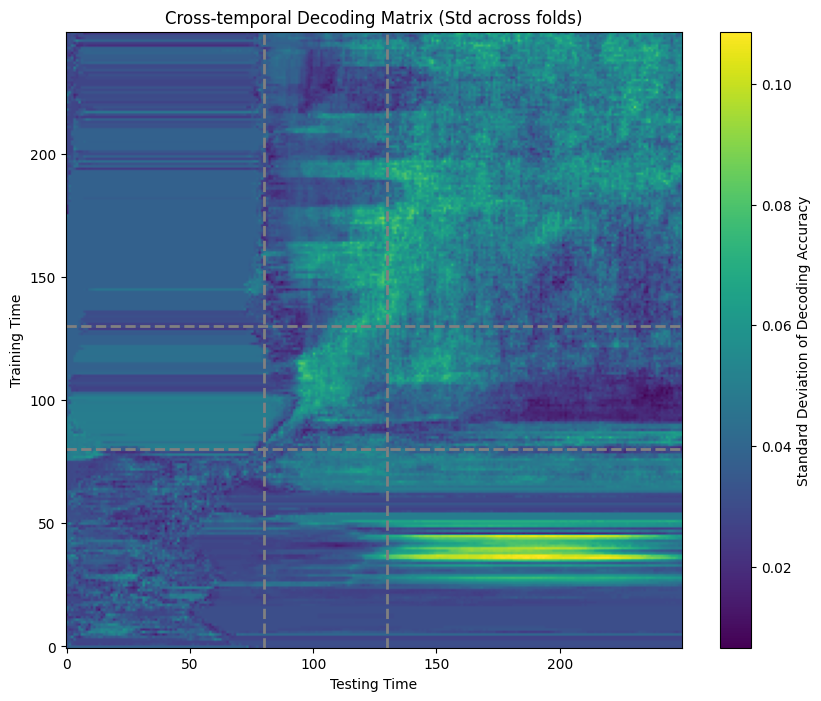

In [6]:
stim_on = 80
stim_dur = 50
stim_off = stim_on + stim_dur


# Plot mean decoding accuracy
plt.figure(figsize=(10, 8))
plt.imshow(decoding_mean, cmap='viridis', origin='lower')
plt.colorbar(label='Mean Decoding Accuracy')
plt.xlabel('Testing Time')
plt.ylabel('Training Time')
plt.title('Cross-temporal Decoding Matrix (Mean across folds)')
# Add gray lines for stimulus timing
plt.axvline(stim_on, color='gray', linestyle='--', linewidth=2)
plt.axvline(stim_off, color='gray', linestyle='--', linewidth=2)
plt.axhline(stim_on, color='gray', linestyle='--', linewidth=2)
plt.axhline(stim_off, color='gray', linestyle='--', linewidth=2)

fname = f"{afc}afc_{coh}_fr{layer}_mod{mod}_mean_shuffled.png"
if save_figures: 
    plt.savefig(fname)   
plt.show()

# Plot standard deviation
plt.figure(figsize=(10, 8))
plt.imshow(decoding_std, cmap='viridis', origin='lower')
plt.colorbar(label='Standard Deviation of Decoding Accuracy')
plt.xlabel('Testing Time')
plt.ylabel('Training Time')
plt.title('Cross-temporal Decoding Matrix (Std across folds)')

# Add gray lines for stimulus timing
plt.axvline(stim_on, color='gray', linestyle='--', linewidth=2)
plt.axvline(stim_off, color='gray', linestyle='--', linewidth=2)
plt.axhline(stim_on, color='gray', linestyle='--', linewidth=2)
plt.axhline(stim_off, color='gray', linestyle='--', linewidth=2)

fname = f"{afc}afc_{coh}_fr{layer}_mod{mod}_std_shuffled.png"
if save_figures:
    plt.savefig(fname)
plt.show()

In [7]:
# permutation tests
from scipy.stats import permutation_test
from mne.stats import permutation_cluster_2samp_test


n_timepoints = decoding_mean.shape[0]

n_permutations = 1000
p_values = np.ones((n_timepoints, n_time_points))


for tx in range(n_timepoints):
    for ty in range(n_timepoints):
        if tx == ty:
            continue  # Skip diagonal (self-comparison)
        
        # Extract decoding values
        d_cross = decoding_mean[tx, ty]
        d_tx = decoding_mean[tx, tx]
        d_ty = decoding_mean[ty, ty]

        # Perform permutation tests
        p1 = permutation_test((decoding_values[tx, ty], decoding_values[tx, tx]),
                              n_resamples=n_permutations, alternative='two-sided').pvalue
        p2 = permutation_test((decoding_values[tx, ty], decoding_values[ty, ty]),
                              n_resamples=n_permutations, alternative='two-sided').pvalue

        # Mark as significant if both tests are significant
        if p1 < 0.05 and p2 < 0.05:
            p_values[tx, ty] = min(p1, p2)  # Store the smaller p-value for clustering




# Threshold for cluster formation (e.g., uncorrected p < 0.05)
significance_mask = p_values < 0.05

# Perform cluster-based correction
T_obs, clusters, cluster_p_values, _ = permutation_cluster_2samp_test(
    decoding_values.reshape(n_timepoints * n_timepoints, -1),
    significance_mask.flatten(),
    n_permutations=n_permutations,
    threshold=0.05,
    tail=0
)

# Reshape results back into a matrix
corrected_p_values = np.ones_like(p_values)
for cluster, p_val in zip(clusters, cluster_p_values):
    if p_val < 0.05:  # Keep only significant clusters
        corrected_p_values[np.unravel_index(cluster, p_values.shape)] = p_val

# Plot significant clusters
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(corrected_p_values < 0.05, cmap='Reds', origin='lower')
plt.colorbar(label='Significant Dynamic Coding (Corrected)')
plt.xlabel('Testing Time')
plt.ylabel('Training Time')
plt.title('Significant Cross-Temporal Decoding')
plt.show()

ModuleNotFoundError: No module named 'mne'